# Project overview:

## Develop a Driver Behavioral Risk Scoring Model that evaluates driving safety risk per trip, and can also summarize risk per driver.

### Key Outcomes:


*  A Trip Risk Score computed using real driving behavior.

* A Driver Risk Score derived from average trip risk.

* Optional mapping & clustering of geographical driving patterns.

### Data Sources:

We use four different datasets in this project:

Trips Data (Ture)
This dataset contains detailed information about each trip a vehicle makes.
It includes when the trip started and ended, where it began and ended, how far the vehicle traveled, the average and maximum speeds during the trip, and the driver who was operating the vehicle.
This dataset forms the base structure for our analysis, because each risk score is calculated per trip.

Eco Driving Data (Økokørsel)
This dataset records events where the driver demonstrates inefficient or aggressive driving behavior, such as harsh braking, rapid acceleration, and unstable driving.
These behaviors are assigned penalty points, which we use to measure how aggressive the driving style was.
This helps us understand the quality of driving, not just the route or speed.

Speeding Data (Hastighedsoverskridelser)
This dataset tracks incidents where the vehicle exceeded the speed limit.
It provides how much the driver was speeding and for how long.
These events are important because speeding is strongly linked to accident risk, so this information becomes a key factor in the risk score.

Driver Summary Sheet
This dataset summarizes the total performance of each driver over a selected period.
It includes total distance driven, average speed, number of trips, and total penalties.
We use this summary to compute a driver-level risk score, based on the average behavior observed across all trips.

### Preprocessing Pipeline:

* Load Excel Sheets
* Translate Danish headers → English standardized fields
* Extract Lat/Lon from Google Maps hyperlinks
* Parse dateformat format (day.month.year)
* Clean durations and convert numeric fields
* Add computed midpoint coordinates:
MidLat = (StartLat + EndLat) / 2
MidLon = (StartLon + EndLon) / 2
* Matching Eco-Driving Violations to Trips: We assign each behavior event (eco-driving or speeding) to the trip during which it occurred by checking whether the event timestamp falls between the trip’s start and end times.
$$
\text{StartTime}_{trip} \;\le\; \text{EventTime} \;\le\; \text{EndTime}_{trip}
$$

* Matching Speeding Events to Trips:
For each speeding event, computed overspeed severity:
$$
\text{OverspeedPct} = 
\frac{\text{MaxSpeed} - \text{SpeedLimit}}{\text{SpeedLimit}} \cdot 100
$$ 
For better interpretability (how much a driver exceeded the speed limit)
* Calculated a severity penalty emphasizing dangerous overspeed: $$\text{SpeedPenaltyScore} = (\text{OverspeedPct})^{2}$$ (heavily penalizes extreme speeding)

Then aggregated per trip:
SpeedEvents:Number of speeding incidents in the trip
MaxOverspeedPct: Highest percentage over limit observed
SpeedPenalty : Sum of squared overspeed severities

* Normalization & Derived Risk Indicators
Because different trips have different lengths and contexts, the core risk indicators were normalized:
PenaltyPer10Km : Adjust harsh driving penalty based on distance traveled
SpeedPenaltyNorm : Scale speeding severity to 0–1 range
PenaltyNorm : Scaled eco-driving penalty (per distance)
ViolationsNorm : Scaled count of violations

* Calculate Trip Risk Score (0–100):
$$
\text{RiskScore}_{raw} =
0.45 \cdot \text{SpeedPenaltyNorm}
+ 0.35 \cdot \text{PenaltyNorm}
+ 0.20 \cdot \text{ViolationsNorm}
$$

We then rescaled this to a 0–100 score

* The RiskScore is calculated as a weighted combination of speeding severity, harsh driving behavior, and the frequency of violations. Speeding receives the highest weight because it has the strongest impact on accident risk, harsh driving has a moderate effect, and the violation count contributes but to a lesser degree. This weighting reflects real-world road safety research and ensures that the score emphasizes behaviors that most strongly increase driving risk.





In [1]:
# %pip install geopy pandas numpy geohash2
import pandas as pd
import numpy as np
from pathlib import Path
from openpyxl import load_workbook
import re

# 1) Report file paths
FILE_TRIPS = Path("data/1001_DP_81162_🗒️Standard_Rapporter_2025-10-23_19-59-58.xlsx") 

# 2) Read sheets (Danish names)
df_trips_raw = pd.read_excel(FILE_TRIPS, sheet_name="Ture")
# Try newest eco sheet first, fall back to the old name if needed
try:
    df_eco_raw = pd.read_excel(FILE_TRIPS, sheet_name="Økokørsel (new)")
except Exception:
    df_eco_raw = pd.read_excel(FILE_TRIPS, sheet_name="Økokørsel")
df_speed_raw = pd.read_excel(FILE_TRIPS, sheet_name="Hastighedsoverskridelser")

# 3) Header translations (Danish → English)
map_trips = {
    "№": "RecordID",
    "Begyndelse": "StartTime",
    "Indledende lokation": "StartLocation",
    "Slut": "EndTime",
    "Endelig lokalitet": "EndLocation",
    "Varighed": "Duration",
    "Kilomertertal": "DistanceKm",
    "CO2 emission": "CO2Emission",
    "Gennemsnitsfart": "AvgSpeed",
    "Max hastighed": "MaxSpeed",
    "Driver 1": "Driver",
    "Trailer": "Trailer",
}

map_eco = {
    "№": "RecordID",
    "Overtrædelse": "Violation",
    "Begyndelse": "StartTime",
    "Indledende lokation": "StartLocation",
    "Slut": "EndTime",
    "Endelig lokalitet": "EndLocation",
    "Værdi": "Value",
    "Straffe": "PenaltyPoints",
    "Varighed": "Duration",
    "Kilomertertal": "DistanceKm",
    "Tæl": "Count",
    "Chauffør": "Driver",
}

map_speed = {
    "Begyndelse": "StartTime",
    "Lokation": "Location",
    "Varighed": "Duration",
    "Chauffør": "Driver",
    "Max hastighed": "MaxSpeed",
    "Hastighedsgrænse": "SpeedLimit",
    
}

# 4) Rename columns to English
df_trips = df_trips_raw.rename(columns=map_trips).copy()
df_eco   = df_eco_raw.rename(columns=map_eco).copy()
df_speed = df_speed_raw.rename(columns=map_speed).copy()

# 5) Extract coordinates from hyperlinks in Ture sheet
wb = load_workbook(FILE_TRIPS, data_only=True)
ws = wb["Ture"]

# Function to extract lat/lon from a URL 
def extract_lat_lon_from_url(url):
    if not url:
        return None, None
    m = re.search(r"q=(-?\d+\.\d+),(-?\d+\.\d+)", url)
    if m:
        return float(m.group(1)), float(m.group(2))
    return None, None

start_lats, start_lons, end_lats, end_lons = [], [], [], []

start_col_index = df_trips_raw.columns.get_loc("Indledende lokation")
end_col_index   = df_trips_raw.columns.get_loc("Endelig lokalitet")

for row in ws.iter_rows(min_row=2):  # skip header
    start_cell = row[start_col_index]
    end_cell   = row[end_col_index]

    start_url = start_cell.hyperlink.target if start_cell.hyperlink else None
    end_url   = end_cell.hyperlink.target if end_cell.hyperlink else None

    lat_s, lon_s = extract_lat_lon_from_url(start_url)
    lat_e, lon_e = extract_lat_lon_from_url(end_url)

    start_lats.append(lat_s)
    start_lons.append(lon_s)
    end_lats.append(lat_e)
    end_lons.append(lon_e)

# Add columns to df_trips
df_trips["StartLat"] = start_lats
df_trips["StartLon"] = start_lons
df_trips["EndLat"]   = end_lats
df_trips["EndLon"]   = end_lons


print(df_trips[["StartLocation","StartLat","StartLon","EndLocation","EndLat","EndLon"]].head())


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                                       StartLocation  StartLat  StartLon  \
0  Værksted: Logistikvej, Syddanmark, Denmark, 2....  55.36436  10.31042   
1  P 100-114: Fynske Motorvej, Syddanmark, Denmar...  55.36565  10.31413   
2  Værksted: Logistikvej, Syddanmark, Denmark, 2....  55.36443  10.31074   
3  DR M: Fynske Motorvej, Syddanmark, Denmark, 2....  55.36541  10.31345   
4  Terminal 3: Logistikvej, Syddanmark, Denmark, ...  55.36403  10.31350   

                                         EndLocation    EndLat    EndLon  
0  P 100-114: Fynske Motorvej, Syddanmark, Denmar...  55.36565  10.31411  
1  Værksted: Logistikvej, Syddanmark, Denmark, 2....  55.36443  10.31074  
2  P 100-114: Fynske Motorvej, Syddanmark, Denmar...  55.36541  10.31355  
3  Terminal 3: Logistikvej, Syddanmark, Denmark, ...  55.36403  10.31350  
4  T4: Logistikvej, Syddanmark, Denmark, 2.28 km ...  55.36394  10.31521  


In [2]:
# Parse with the correct format (day.month.year)
df_trips['StartTime'] = pd.to_datetime(df_trips['StartTime'], format='%d.%m.%Y %H:%M:%S')
df_trips['EndTime'] = pd.to_datetime(df_trips['EndTime'], format='%d.%m.%Y %H:%M:%S')

# Parse Duration (if it's in HH:MM:SS format)
df_trips['Duration'] = pd.to_timedelta(df_trips['Duration'])

df_eco['StartTime'] = pd.to_datetime(df_eco['StartTime'], format='%d.%m.%Y %H:%M:%S')
df_eco['EndTime'] = pd.to_datetime(df_eco['EndTime'], format='%d.%m.%Y %H:%M:%S')
df_eco['Duration'] = df_eco['EndTime'] - df_eco['StartTime']


df_speed['StartTime'] = pd.to_datetime(df_speed['StartTime'], format='%d.%m.%Y %H:%M:%S')
df_speed['Duration'] = pd.to_timedelta(df_speed['Duration'])

df_eco['Duration'] = pd.to_timedelta(df_eco['Duration'], errors='coerce')
# Convert to string and extract just the time part
df_eco['Duration_formatted'] = df_eco['Duration'].astype(str).str.split(' days ').str[-1]


In [3]:
# Delete DistanceKm column in df_eco
df_eco = df_eco.drop(columns=['DistanceKm'], errors='ignore')
# replace Duration with Duration_formatted and delete Duration_formatted
df_eco['Duration'] = df_eco['Duration_formatted']
df_eco = df_eco.drop(columns=['Duration_formatted'], errors='ignore')

In [4]:
# Use errors='coerce' to convert invalid values to NaT
df_trips['Duration'] = pd.to_timedelta(df_trips['Duration'], errors='coerce')
# Convert to string and extract just the time part
df_trips['Duration_formatted'] = df_trips['Duration'].astype(str).str.split(' days ').str[-1]

# replace Duration with Duration_formatted and delete Duration_formatted
df_trips['Duration'] = df_trips['Duration_formatted']
df_trips = df_trips.drop(columns=['Duration_formatted'], errors='ignore')

In [5]:
# count df_eco values CO2Emission
df_trips['CO2Emission'].value_counts()

# delete CO2Emission column
df_trips = df_trips.drop(columns=['CO2Emission'], errors='ignore')

df_trips['Trailer'].value_counts()

# All values are NaN so we can drop this column
df_trips = df_trips.drop(columns=['Trailer'], errors='ignore')


In [6]:
# columns names in df_eco
df_eco.head()

,RecordID,Violation,StartTime,StartLocation,EndTime,EndLocation,Value,PenaltyPoints,Duration,Count,Driver
0,1,Brake: medium,2024-10-09 07:23:53,"Logistikvej, Højme, 5250 Odense SV, Denmark",2024-10-09 07:24:05,"Logistikvej, Højme, 5250 Odense SV, Denmark",0.17 g,500,00:00:12,1,Kim Hjortekær
1,2,Brake: medium,2024-10-09 07:24:19,anna,2024-10-09 07:24:34,anna,0.17 g,500,00:00:15,1,Kim Hjortekær
2,3,Turn: medium,2024-10-09 07:35:51,anna,2024-10-09 07:35:53,anna,0.17 g,500,00:00:02,1,Kim Hjortekær
3,4,Brake: medium,2024-10-09 07:39:43,anna,2024-10-09 07:40:03,anna,0.18 g,500,00:00:20,1,Kim Hjortekær
4,5,Acceleration: medium,2024-10-09 08:04:33,"Nyborgvej 634, Fraugdekærby, 5220 Odense SØ, D...",2024-10-09 08:04:53,"Nyborgvej 652, Fraugdekærby, 5220 Odense SØ, D...",0.16 g,500,00:00:20,1,Kim Hjortekær


## Feature engineering

In [7]:
import pandas as pd
import numpy as np

# ---- 0) Start from your source tables ----
# df_trips and df_eco must already be loaded.
# Create the working trips dataframe `df`
df = df_trips.copy()

# Ensure expected trip columns exist
need_cols = {"RecordID","Driver","StartTime","EndTime"}
missing = need_cols - set(df.columns)
if missing:
    raise ValueError(f"df_trips is missing required columns: {missing}")

# Ensure target columns exist (create if absent)
for col in ["Penalty","ViolationCount"]:
    if col not in df.columns:
        df[col] = 0

# ---- 1) Parse datetimes & normalize driver IDs ----
df["StartTime"] = pd.to_datetime(df["StartTime"], errors="coerce")
df["EndTime"]   = pd.to_datetime(df["EndTime"],   errors="coerce")
df["Driver"]    = df["Driver"].astype(str).str.strip()

df_eco = df_eco.copy()
df_eco["StartTime"] = pd.to_datetime(df_eco["StartTime"], errors="coerce")
df_eco["EndTime"]   = pd.to_datetime(df_eco["EndTime"],   errors="coerce")
df_eco["Driver"]    = df_eco["Driver"].astype(str).str.strip()

# ---- 2) Pick the penalty column from df_eco ----
eco_pen_col = "PenaltyPoints" if "PenaltyPoints" in df_eco.columns else (
              "ViolationCount" if "ViolationCount" in df_eco.columns else None)
if eco_pen_col is None:
    raise ValueError("df_eco must contain either 'PenaltyPoints' or 'ViolationCount'.")

# ---- 3) Build minimal merge inputs (avoid name collisions) ----
trips_m = df[["RecordID","Driver","StartTime","EndTime"]].copy()
trips_m["TripDate"] = trips_m["StartTime"].dt.date

eco_m = df_eco[["Driver","StartTime", eco_pen_col]].copy()
eco_m["EventDate"] = eco_m["StartTime"].dt.date

# ---- 4) Merge by Driver + Date, then filter within trip window ----
merged = eco_m.merge(
    trips_m[["RecordID","Driver","TripDate","StartTime","EndTime"]],
    left_on=["Driver","EventDate"],
    right_on=["Driver","TripDate"],
    how="inner"
)

mask = (merged["StartTime_x"] >= merged["StartTime_y"]) & (merged["StartTime_x"] <= merged["EndTime"])
matches = merged[mask].copy()

# ---- 5) Aggregate penalties per trip ----
matches[eco_pen_col] = pd.to_numeric(matches[eco_pen_col], errors="coerce").fillna(0)

agg = matches.groupby("RecordID")[eco_pen_col].agg(
    Penalty="sum",              # trip penalty = sum of eco penalties
    ViolationCount="count"      # frequency = number of matched events
).reset_index()

# ---- 6) Merge aggregates back into df ----
df = df.merge(agg.rename(columns={
        "Penalty":"Penalty_agg",
        "ViolationCount":"ViolationCount_agg"
     }),
     on="RecordID", how="left"
)

df["Penalty"]        = pd.to_numeric(df["Penalty_agg"], errors="coerce").fillna(0).astype(float)
df["ViolationCount"] = pd.to_numeric(df["ViolationCount_agg"], errors="coerce").fillna(0).astype(int)

# ---- 7) Cleanup temp columns ----
df = df.drop(columns=[c for c in ["TripDate","Penalty_agg","ViolationCount_agg"] if c in df.columns], errors="ignore")

print("Trips with penalties:", int((df["Penalty"] > 0).sum()), "out of", len(df))
df.head(10)

# Save the CSV
output_path = "trips_with_penalty.csv"

df.to_csv(output_path, index=False)


Trips with penalties: 3617 out of 4232


In [8]:
# --- PREPARE SPEED DATA ---

# Ensure datetime
df_speed["StartTime"] = pd.to_datetime(df_speed["StartTime"], errors="coerce")
df["StartTime"] = pd.to_datetime(df["StartTime"], errors="coerce")
df["EndTime"] = pd.to_datetime(df["EndTime"], errors="coerce")

# Normalize driver text
df_speed["Driver"] = df_speed["Driver"].astype(str).str.strip()
df["Driver"]       = df["Driver"].astype(str).str.strip()

# Create date keys 
df_speed["EventDate"] = df_speed["StartTime"].dt.date
df["TripDate"] = df["StartTime"].dt.date

# Merge speed events to trips (Driver + Date first)
merged_speed = df_speed.merge(
    df[["RecordID","Driver","TripDate","StartTime","EndTime"]],
    left_on=["Driver","EventDate"],
    right_on=["Driver","TripDate"],
    how="inner"
)

# Keep only events inside the trip time window
mask = (merged_speed["StartTime_x"] >= merged_speed["StartTime_y"]) & (merged_speed["StartTime_x"] <= merged_speed["EndTime"])
speed_matches = merged_speed[mask].copy()

# Compute overspeed severity
speed_matches["OverspeedPct"] = (speed_matches["MaxSpeed"] - speed_matches["SpeedLimit"]) / speed_matches["SpeedLimit"] * 100
speed_matches["OverspeedPct"] = speed_matches["OverspeedPct"].clip(lower=0).fillna(0)

# Compute severity penalty (squared to emphasize high-speed violations)
speed_matches["SpeedPenaltyScore"] = (speed_matches["OverspeedPct"] ** 2)

# Aggregate into trip-level features
speed_agg = speed_matches.groupby("RecordID").agg(
    SpeedEvents=("OverspeedPct","count"),
    MaxOverspeedPct=("OverspeedPct","max"),
    SpeedPenalty=("SpeedPenaltyScore","sum")
).reset_index()

# Merge into df
df = df.merge(speed_agg, on="RecordID", how="left")

# Fill trips with no speeding
df["SpeedEvents"] = df["SpeedEvents"].fillna(0).astype(int)
df["MaxOverspeedPct"] = df["MaxOverspeedPct"].fillna(0)
df["SpeedPenalty"] = df["SpeedPenalty"].fillna(0)

# Cleanup
df = df.drop(columns=["TripDate"], errors="ignore")

df.head(10)


,RecordID,StartTime,StartLocation,EndTime,EndLocation,Duration,DistanceKm,AvgSpeed,MaxSpeed,Driver,StartLat,StartLon,EndLat,EndLon,Penalty,ViolationCount,SpeedEvents,MaxOverspeedPct,SpeedPenalty
0,1,2024-10-02 10:45:30,"Værksted: Logistikvej, Syddanmark, Denmark, 2....",2024-10-02 10:49:33,"P 100-114: Fynske Motorvej, Syddanmark, Denmar...",00:04:03,0.480,7.111111,29,-----,55.36436,10.31042,55.36565,10.31411,0.0,0,0,0.0,0.0
1,2,2024-10-03 11:11:46,"P 100-114: Fynske Motorvej, Syddanmark, Denmar...",2024-10-03 11:13:45,"Værksted: Logistikvej, Syddanmark, Denmark, 2....",00:01:59,0.310,9.378151,24,-----,55.36565,10.31413,55.36443,10.31074,0.0,0,0,0.0,0.0
2,3,2024-10-03 15:00:28,"Værksted: Logistikvej, Syddanmark, Denmark, 2....",2024-10-03 15:02:31,"P 100-114: Fynske Motorvej, Syddanmark, Denmar...",00:02:03,0.400,11.707317,27,-----,55.36443,10.31074,55.36541,10.31355,0.0,0,0,0.0,0.0
3,4,2024-10-09 06:58:41,"DR M: Fynske Motorvej, Syddanmark, Denmark, 2....",2024-10-09 06:59:51,"Terminal 3: Logistikvej, Syddanmark, Denmark, ...",00:01:10,0.240,12.342857,17,-----,55.36541,10.31345,55.36403,10.31350,0.0,0,0,0.0,0.0
4,5,2024-10-09 07:08:12,"Terminal 3: Logistikvej, Syddanmark, Denmark, ...",2024-10-09 07:09:23,"T4: Logistikvej, Syddanmark, Denmark, 2.28 km ...",00:01:11,0.170,8.619718,25,Kim Hjortekær,55.36403,10.31350,55.36394,10.31521,0.0,0,0,0.0,0.0
5,6,2024-10-09 07:21:31,"T4: Logistikvej, Syddanmark, Denmark, 2.28 km ...",2024-10-09 07:42:35,"Brejdablik 8, Fraugdekærby, 5220 Odense SØ, De...",00:21:04,17.195,48.973101,89,Kim Hjortekær,55.36394,10.31521,55.38580,10.49138,2000.0,4,0,0.0,0.0
6,7,2024-10-09 08:03:25,"Brejdablik 8, Fraugdekærby, 5220 Odense SØ, De...",2024-10-09 08:11:26,"Gartnervænget 3, 5550 Langeskov, Denmark",00:08:01,6.370,47.675676,80,Kim Hjortekær,55.38580,10.49138,55.37027,10.57205,1500.0,3,0,0.0,0.0
7,8,2024-10-09 08:20:27,"Gartnervænget 3, 5550 Langeskov, Denmark",2024-10-09 08:47:47,"P 12-22: Fynske Motorvej, Syddanmark, Denmark,...",00:27:20,20.805,45.669512,89,Kim Hjortekær,55.37032,10.57201,55.36603,10.30941,7100.0,9,0,0.0,0.0
8,9,2024-10-09 09:03:26,"P 12-22: Fynske Motorvej, Syddanmark, Denmark,...",2024-10-09 09:05:34,"P 66-74: Fynske Motorvej, Syddanmark, Denmark,...",00:02:08,0.450,12.656250,24,Kim Hjortekær,55.36603,10.30941,55.36552,10.31246,0.0,0,0,0.0,0.0
9,10,2024-10-09 09:28:10,"P 66-74: Fynske Motorvej, Syddanmark, Denmark,...",2024-10-09 09:47:43,"Gartnervænget 1, 5550 Langeskov, Denmark",00:19:33,20.510,62.946292,91,Kim Hjortekær,55.36552,10.31245,55.37016,10.56973,4500.0,6,0,0.0,0.0


In [9]:
# make only 2 decimal places for MaxOverspeedPct and SpeedPenalty
df["MaxOverspeedPct"] = df["MaxOverspeedPct"].round(2)
df["SpeedPenalty"]    = df["SpeedPenalty"].round(2)
# give some rows where MaxOverspeedPct is not null
df[df["MaxOverspeedPct"] > 0].head()

,RecordID,StartTime,StartLocation,EndTime,EndLocation,Duration,DistanceKm,AvgSpeed,MaxSpeed,Driver,StartLat,StartLon,EndLat,EndLon,Penalty,ViolationCount,SpeedEvents,MaxOverspeedPct,SpeedPenalty
33,34,2024-10-10 11:53:00,"P 66-74: Fynske Motorvej, Syddanmark, Denmark,...",2024-10-10 12:21:00,"Rugårdsvej 887, Hindevad, 5471 Søndersø, Denmark",00:28:00,30.025,64.339286,109,Kim Hjortekær,55.36554,10.31246,55.46036,10.09630,9100.0,19,1,26.00,676.00
40,41,2024-10-11 10:48:50,"Cool logistics: Fynske Motorvej, 5260 Odense, ...",2024-10-11 12:06:46,"Hedegyden 20, Ellerup, 5892 Gudbjerg Sydfyn, D...",01:17:56,62.430,48.064157,90,Kim Hjortekær,55.35082,10.40375,55.17462,10.63614,35800.0,63,1,24.00,576.00
59,60,2024-10-14 13:39:22,"P 35-41: Fynske Motorvej, Syddanmark, Denmark,...",2024-10-14 13:59:03,"Tvingvej 33, Birkum, 5220 Odense SØ, Denmark",00:19:41,18.310,55.813717,90,Kim Hjortekær,55.36571,10.31070,55.34617,10.51631,13000.0,24,1,24.00,576.00
109,110,2024-10-18 08:04:53,"Priorensgade 73, 5600 Faaborg, Denmark",2024-10-18 08:46:30,"Logistikvej 18, Højme, 5250 Odense SV, Denmark",00:41:37,40.145,57.878254,89,Kim Hjortekær,55.09382,10.25254,55.36179,10.31666,13900.0,28,1,18.33,336.11
111,112,2024-10-18 09:14:29,"P 35-41: Fynske Motorvej, Syddanmark, Denmark,...",2024-10-18 09:28:44,"Cool logistics: Fynske Motorvej, 5260 Odense, ...",00:14:15,9.505,40.021053,89,Kim Hjortekær,55.36563,10.31049,55.35067,10.40354,11700.0,19,1,28.00,784.00


In [10]:
# number of non null penalty rows
df[df["Penalty"] > 0].shape[0]

3617

## Normalizing measures

In [11]:
# normalize penalty by Distance
import numpy as np

# normalize penalty by Distance
df["PenaltyPer10Km"] = np.where(df["DistanceKm"] > 0,
                                 10 * df["Penalty"] / df["DistanceKm"],
                                 0)


# Normalize Speed Penalty (scaled 0–1)
# Small epsilon to avoid divide-by-zero
max_speed_pen = df["SpeedPenalty"].max() if df["SpeedPenalty"].max() > 0 else 1

df["SpeedPenaltyNorm"] = df["SpeedPenalty"] / max_speed_pen


# Normalize Eco Penalty & Violations (scaled 0–1)
max_penalty = df["PenaltyPer10Km"].max() if df["PenaltyPer10Km"].max() > 0 else 1
df["PenaltyNorm"] = df["PenaltyPer10Km"] / max_penalty

max_viol = df["ViolationCount"].max() if df["ViolationCount"].max() > 0 else 1
df["ViolationsNorm"] = df["ViolationCount"] / max_viol


In [12]:
# Combine into RiskScore (0–100)
#SpeedPenaltyNorm	0.45	Speeding is the strongest safety predictor
#PenaltyNorm	0.35	Harsh behaviour strongly impacts safety & fuel
#ViolationsNorm	0.20	Number of events matters but less than severity


df["RiskScore_raw"] = (
    0.45 * df["SpeedPenaltyNorm"] +
    0.35 * df["PenaltyNorm"] +
    0.20 * df["ViolationsNorm"]
)

# Scale to 0–100
df["RiskScore"] = (df["RiskScore_raw"] - df["RiskScore_raw"].min()) / \
                  (df["RiskScore_raw"].max() - df["RiskScore_raw"].min()) * 100



In [13]:
# export final file
import pandas as pd
# Replace filename if you want a different name
output_path = "trips_final_with_riskscore.csv"

# save final data
df.to_csv(output_path, index=False)

## Data analysis

### We explored the cleaned final trip dataset to understand driving behavior patterns, and vizualise 

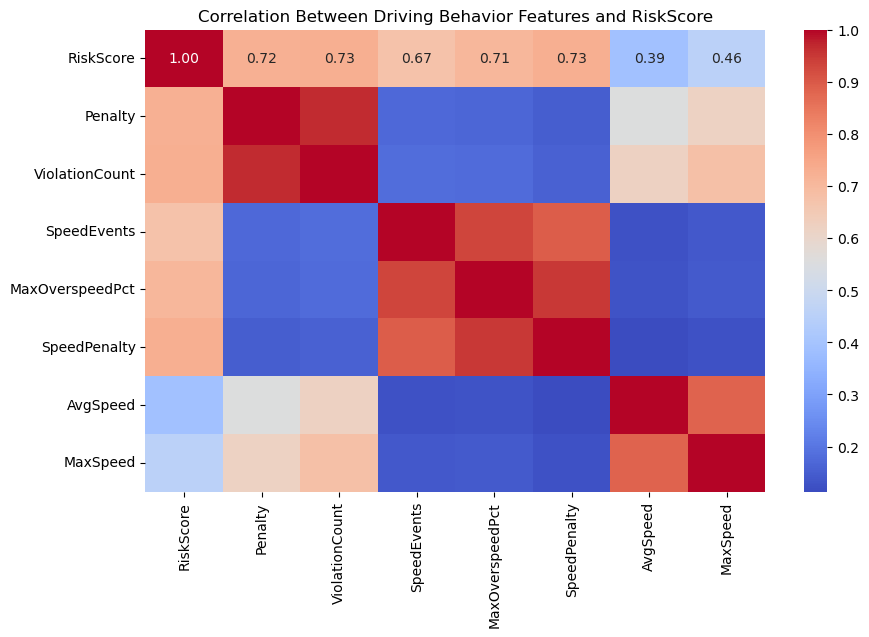

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
corr = df[["RiskScore", "Penalty", "ViolationCount", "SpeedEvents", "MaxOverspeedPct", "SpeedPenalty", "AvgSpeed", "MaxSpeed"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Driving Behavior Features and RiskScore")
plt.show()


In [15]:
# Create Driver Risk Profiles

driver_scores = df.groupby("Driver").agg(
    Trips=("RecordID","count"),
    AvgRisk=("RiskScore","mean"),
    MaxTripRisk=("RiskScore","max"),
    TotalPenalty=("Penalty","sum"),
    TotalSpeedEvents=("SpeedEvents","sum")
).reset_index().sort_values("AvgRisk", ascending=False)

driver_scores


,Driver,Trips,AvgRisk,MaxTripRisk,TotalPenalty,TotalSpeedEvents
1,Jens-Erik Nielsen,1,19.534939,19.534939,18800.0,0
8,Niclas Juel Boye Pedersen,14,17.065258,100.000000,134400.0,3
7,Møller Silas Christian,8,10.417474,35.652876,75100.0,0
0,-----,56,9.457157,98.011207,399100.0,2
9,Niels Hørlück,1,9.453501,9.453501,7300.0,0
4,Kim Hjortekær,1288,9.099467,96.755099,7635800.0,78
5,Mads Nielsen,2725,8.553433,83.625085,18476800.0,55
2,Jensen Nikolaj Gervig,29,7.857504,17.717076,183200.0,0
12,Tonny Kent Skiøth,65,6.300562,20.784597,332700.0,0
10,Theis Olsen,32,5.695704,17.017796,144000.0,0


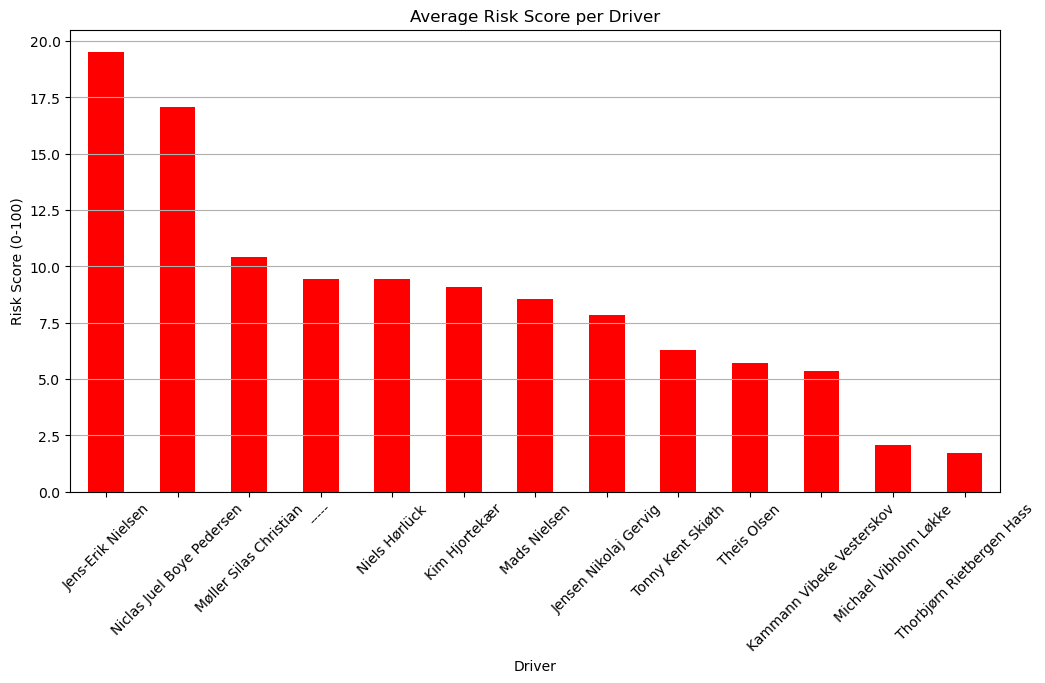

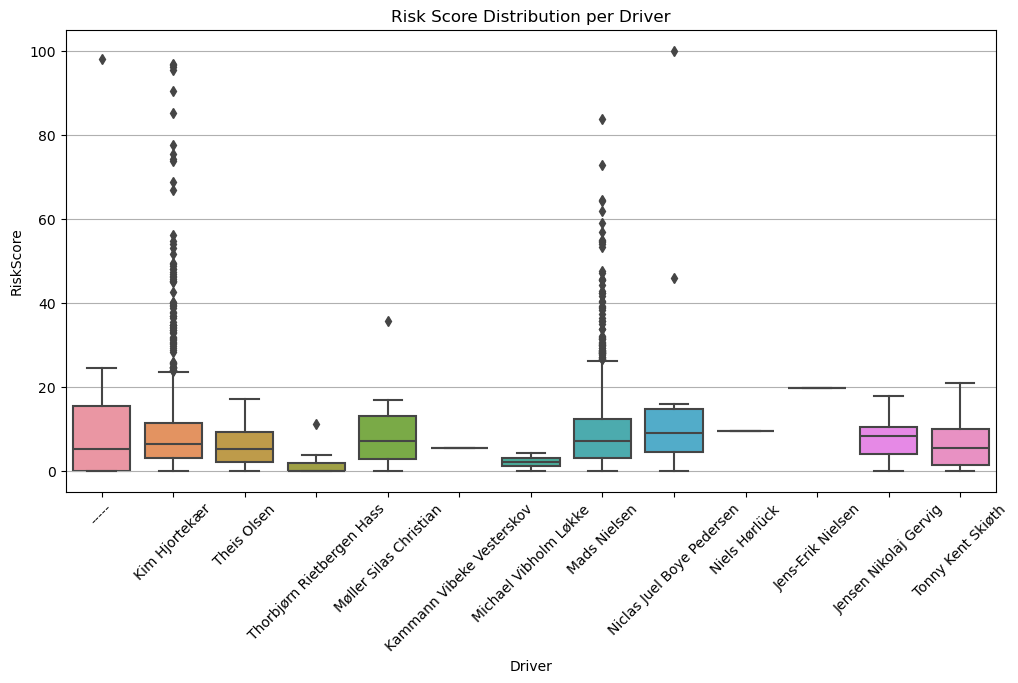

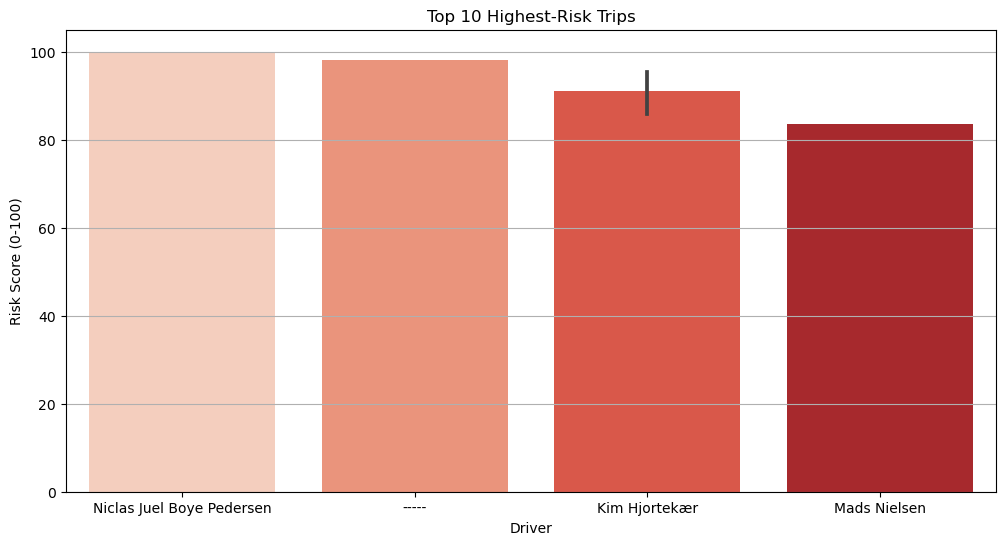

,Driver,RiskScore,DistanceKm,Penalty,SpeedEvents
1676,Niclas Juel Boye Pedersen,100.000000,12.355,33100.0,2
162,-----,98.011207,23.470,23000.0,2
449,Kim Hjortekær,96.755099,12.065,21000.0,1
199,Kim Hjortekær,96.516346,17.070,15700.0,1
1031,Kim Hjortekær,96.186607,16.315,13400.0,3
798,Kim Hjortekær,95.266806,16.165,19200.0,2
642,Kim Hjortekær,90.410883,9.890,8700.0,1
800,Kim Hjortekær,85.224153,16.710,13700.0,2
1430,Mads Nielsen,83.625085,17.035,16500.0,1
1255,Kim Hjortekær,77.581736,31.035,40700.0,1


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Compute average risk per driver
driver_risk = df.groupby("Driver")["RiskScore"].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
driver_risk.plot(kind="bar", color="red")
plt.title("Average Risk Score per Driver")
plt.ylabel("Risk Score (0-100)")
plt.xlabel("Driver")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 2) Distribution of risk score per driver
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="Driver", y="RiskScore")
plt.title("Risk Score Distribution per Driver")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# 3) Top 10 highest-risk trips
top10 = df.nlargest(10, "RiskScore")[["Driver","RiskScore","DistanceKm","Penalty","SpeedEvents"]]

plt.figure(figsize=(12,6))
sns.barplot(data=top10, x="Driver", y="RiskScore", palette="Reds")
plt.title("Top 10 Highest-Risk Trips")
plt.ylabel("Risk Score (0-100)")
plt.grid(axis='y')
plt.show()

top10


In [17]:
import plotly.express as px

# Compute midpoint for visualization
df["Lat"] = (df["StartLat"] + df["EndLat"]) / 2
df["Lon"] = (df["StartLon"] + df["EndLon"]) / 2

fig = px.scatter_geo(
    df,
    lat="Lat",
    lon="Lon",
    color="RiskScore",
    hover_name="Driver",
    hover_data=["RiskScore", "DistanceKm", "Penalty", "SpeedEvents"],
    color_continuous_scale="RdYlGn_r",   # green=low risk → red=high risk
    range_color=(0,100),
    size="RiskScore",
    projection="natural earth",
    title="Trip Risk Map (Colored by Risk Score)"
)

fig.show()

